In [1]:
#!pip install gensim
#!pip install razdel
#pip install pymorphy2

In [2]:
import pandas as pd
import numpy as np

from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

import nltk
nltk.download('stopwords')

#предобработка текстов
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from razdel import tokenize

import pymorphy2  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Evgeniya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [4]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### Работа с текстами

In [5]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [6]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [7]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|['nn']", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [8]:
%%time

# Очистка текста

news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 8.67 s, sys: 122 ms, total: 8.8 s
Wall time: 8.91 s


In [9]:
%%time

# Лемматизация текста

news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 6min 44s, sys: 2.09 s, total: 6min 46s
Wall time: 6min 49s


#### Обучение модели 

In [10]:
# Формированение списка текстов 

texts = [t for t in news['title'].values]

# Создние корпуса из списка текстов

common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [11]:
%%time

from gensim.models import LdaModel

# Обучение модели на корпусе

# Гиперпараметры: num_topics - кличество тем, необходимо подбирать 

lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 43s, sys: 2.75 s, total: 1min 46s
Wall time: 1min 13s


In [12]:
from gensim.test.utils import datapath

# Сохранение модели

temp_file = datapath("model.lda")
lda.save(temp_file)

# Загрузка модели

lda = LdaModel.load(temp_file)

In [13]:
# Вывод топ-слов по теме (порядок имеет значение)

x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: пресссекретарить превысить выдать путин ми песок функционировать
topic_1: авария болезнь сократиться употребление датчик пить актёр
topic_2: надёжный лодка кресло лестница антонов корзина электроника
topic_3: россия российский рубль рост область гражданин тыс
topic_4: научный проект риск новый район программа китай
topic_5: газ пострадать район турция автомобиль канал египет
topic_6: поверхность ресурс парламент выпуск совместно сахар наращивать
topic_7: фестиваль японский япония корея нахождение вена корейский
topic_8: исследование военный фонд тело расследование белый данные
topic_9: сша американский первый россия день помощь операция
topic_10: рак товар бензин автор компьютер миллиард связанный
topic_11: млрд ракета погибнуть двигатель связанный экипаж температура
topic_12: снижение пациент иск автор проживать приоритетный снизить
topic_13: остров иран определение озеро японский сход макс
topic_14: смерть министерство наука километр мышь выдавать подразделение
topic_15: бом

In [14]:
# Функция, возвращающая векторное представление новости

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [15]:
# Векторное представление новостей

topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.558966,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.270142,0.00000,0.000000,0.000000,0.000000,0.0,0.155995,0.000000
1,4896,0.0,0.0,0.0,0.569220,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.403671,0.000000
2,4897,0.0,0.0,0.0,0.318822,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.00000,0.107456,0.000000,0.000000,0.0,0.548562,0.000000
3,4898,0.0,0.0,0.0,0.000000,0.195414,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.381512,0.217522
4,4899,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.542293,0.05208,0.000000,0.334963,0.042531,0.0,0.000000,0.000000


In [16]:
# Словарь, который по id выводит вектор тем

doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

### Работа с пользователями

In [17]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [18]:
# Функция, определяющая интересы пользователя исходя из прочитанных статей

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [19]:
# Интересы первого пользователя

user_articles_list = users['articles'].iloc[0]

get_user_embedding(user_articles_list)

array([0.        , 0.01165853, 0.        , 0.20628937, 0.08511686,
       0.0043208 , 0.        , 0.01240141, 0.04513947, 0.02041799,
       0.00840125, 0.00426462, 0.01890366, 0.        , 0.        ,
       0.00304432, 0.00249025, 0.13466439, 0.03521802, 0.00599519,
       0.06253924, 0.        , 0.05939386, 0.06819704, 0.18674294])

In [20]:
# Функция, формирующая вектора по пользователям

def user_embeddings_dataframe():
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]] 
    return user_embeddings

In [21]:
user_embeddings = user_embeddings_dataframe()
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.011659,0.0,0.206289,0.085117,0.004321,0.0,0.012401,0.045139,...,0.003044,0.002490,0.134664,0.035218,0.005995,0.062539,0.0,0.059394,0.068197,0.186743
1,u108690,0.005281,0.002768,0.0,0.215131,0.024081,0.018952,0.0,0.000000,0.043078,...,0.000000,0.000000,0.087358,0.023246,0.023485,0.032916,0.0,0.026752,0.036558,0.267812
2,u108339,0.000000,0.021587,0.0,0.180588,0.097170,0.024846,0.0,0.000000,0.095394,...,0.000000,0.005685,0.141745,0.000000,0.062970,0.009165,0.0,0.012962,0.025484,0.092964


In [22]:
# Загрузка разметки

target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [23]:
# Объединение данных по пользователям и целевой переменной

X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.011659,0.0,0.206289,0.085117,0.004321,0.0,0.012401,0.045139,...,0.002490,0.134664,0.035218,0.005995,0.062539,0.0,0.059394,0.068197,0.186743,0
1,u108690,0.005281,0.002768,0.0,0.215131,0.024081,0.018952,0.0,0.000000,0.043078,...,0.000000,0.087358,0.023246,0.023485,0.032916,0.0,0.026752,0.036558,0.267812,1
2,u108339,0.000000,0.021587,0.0,0.180588,0.097170,0.024846,0.0,0.000000,0.095394,...,0.005685,0.141745,0.000000,0.062970,0.009165,0.0,0.012962,0.025484,0.092964,1


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import itertools

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix

%matplotlib inline

In [25]:
# Разбивка датасета на train и test 

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], test_size=0.30, random_state=0)

In [26]:
# Применяемая модель - Логистическая регрессия

logreg = LogisticRegression()

In [27]:
# Обучение модели

logreg.fit(X_train, y_train)

LogisticRegression()

In [28]:
# Прогноз для тестовой выборки

preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06170494, 0.00866512, 0.47135235, 0.33406964, 0.03786769,
       0.097106  , 0.1741923 , 0.03037071, 0.07342656, 0.14873598])

In [29]:
# Расчет метрик 

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.248314, F-Score=0.624, Precision=0.538, Recall=0.741


In [30]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9277461282155531

In [31]:
metrics_basic = (fscore[ix], precision[ix], recall[ix], roc_auc)
metrics_basic

(0.6235632183908046,
 0.5384615384615384,
 0.7406143344709898,
 0.9277461282155531)

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1921  186]
 [  77  216]]


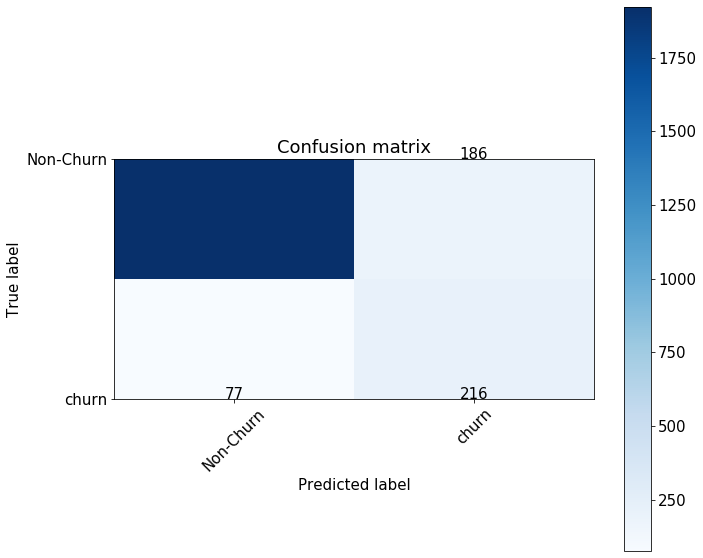

In [33]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### Модифицированная модель (расчет медианы при построении векторов)

In [34]:
# Модифицированная функция, определяющая интересы пользователя исходя из прочитанных статей

def get_user_embedding_mod_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [35]:
# Модифицированная функция построения векторов

def user_embeddings_dataframe_mod_median():
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mod_median(x), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]] 
    return user_embeddings

In [36]:
user_embeddings = user_embeddings_dataframe_mod_median()
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.0,0.197170,0.085692,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.081413,0.000000,0.000000,0.040466,0.0,0.021620,0.040893,0.239086
1,u108690,0.0,0.000000,0.0,0.245237,0.007552,0.007957,0.0,0.0,0.035839,...,0.0,0.0,0.068774,0.022859,0.024372,0.005950,0.0,0.022593,0.016939,0.265685
2,u108339,0.0,0.009473,0.0,0.179928,0.098563,0.034787,0.0,0.0,0.076786,...,0.0,0.0,0.170395,0.000000,0.043994,0.000000,0.0,0.000000,0.000000,0.107075


In [37]:
# Объединение данных по пользователям и целевой переменной

X_median = pd.merge(user_embeddings, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.0,0.197170,0.085692,0.000000,0.0,0.0,0.000000,...,0.0,0.081413,0.000000,0.000000,0.040466,0.0,0.021620,0.040893,0.239086,0
1,u108690,0.0,0.000000,0.0,0.245237,0.007552,0.007957,0.0,0.0,0.035839,...,0.0,0.068774,0.022859,0.024372,0.005950,0.0,0.022593,0.016939,0.265685,1
2,u108339,0.0,0.009473,0.0,0.179928,0.098563,0.034787,0.0,0.0,0.076786,...,0.0,0.170395,0.000000,0.043994,0.000000,0.0,0.000000,0.000000,0.107075,1


In [38]:
# Разбивка датасета на train и test 

X_train, X_test, y_train, y_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [39]:
# Обучение модели

logreg.fit(X_train, y_train)

LogisticRegression()

In [40]:
# Прогноз для тестовой выборки

preds = logreg.predict_proba(X_test)[:, 1]
preds[:5]

array([0.15394915, 0.00752741, 0.63263978, 0.4249241 , 0.02893495])

In [41]:
# Расчет метрик 

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.249873, F-Score=0.692, Precision=0.596, Recall=0.824


In [42]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9514832257689401

In [43]:
metrics_mod_median = (fscore[ix], precision[ix], recall[ix], roc_auc)
metrics_mod_median

(0.6917808219178082,
 0.5958702064896755,
 0.8244897959183674,
 0.9514832257689401)

Confusion matrix, without normalization
[[1618  137]
 [  44  201]]


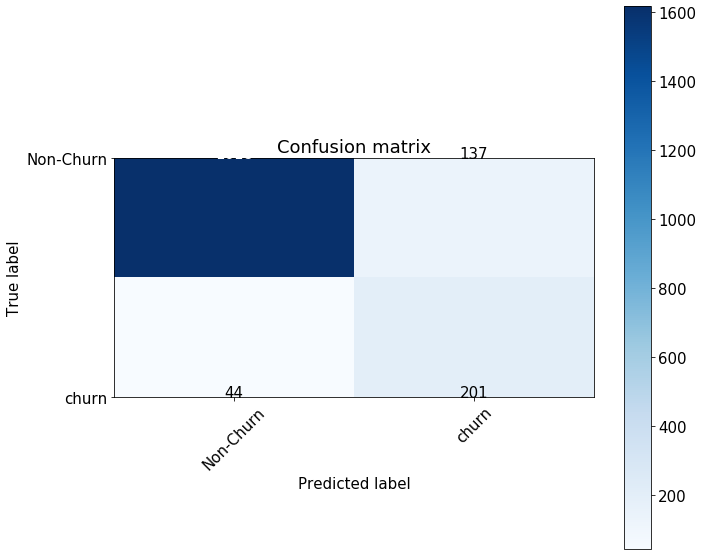

In [44]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### Модифицированная модель (расчет максимального значения при построении векторов)

In [45]:
# Модифицированная функция, определяющая интересы пользователя исходя из прочитанных статей

def get_user_embedding_mod_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [46]:
# Модифицированная функция построения векторов

def user_embeddings_dataframe_mod_max():
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mod_max(x), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]] 
    return user_embeddings

In [47]:
user_embeddings = user_embeddings_dataframe_mod_max()
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.0,0.197170,0.085692,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.081413,0.000000,0.000000,0.040466,0.0,0.021620,0.040893,0.239086
1,u108690,0.0,0.000000,0.0,0.245237,0.007552,0.007957,0.0,0.0,0.035839,...,0.0,0.0,0.068774,0.022859,0.024372,0.005950,0.0,0.022593,0.016939,0.265685
2,u108339,0.0,0.009473,0.0,0.179928,0.098563,0.034787,0.0,0.0,0.076786,...,0.0,0.0,0.170395,0.000000,0.043994,0.000000,0.0,0.000000,0.000000,0.107075


In [48]:
# Объединение данных по пользователям и целевой переменной

X_max = pd.merge(user_embeddings, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.0,0.197170,0.085692,0.000000,0.0,0.0,0.000000,...,0.0,0.081413,0.000000,0.000000,0.040466,0.0,0.021620,0.040893,0.239086,0
1,u108690,0.0,0.000000,0.0,0.245237,0.007552,0.007957,0.0,0.0,0.035839,...,0.0,0.068774,0.022859,0.024372,0.005950,0.0,0.022593,0.016939,0.265685,1
2,u108339,0.0,0.009473,0.0,0.179928,0.098563,0.034787,0.0,0.0,0.076786,...,0.0,0.170395,0.000000,0.043994,0.000000,0.0,0.000000,0.000000,0.107075,1


In [49]:
# Разбивка датасета на train и test 

X_train, X_test, y_train, y_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [50]:
# Обучение модели

logreg.fit(X_train, y_train)

LogisticRegression()

In [51]:
# Прогноз для тестовой выборки

preds = logreg.predict_proba(X_test)[:, 1]
preds[:5]

array([0.15394915, 0.00752741, 0.63263978, 0.4249241 , 0.02893495])

In [52]:
# Расчет метрик 

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.249873, F-Score=0.692, Precision=0.596, Recall=0.824


In [53]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9514832257689401

In [54]:
metrics_mod_max = (fscore[ix], precision[ix], recall[ix], roc_auc)
metrics_mod_max

(0.6917808219178082,
 0.5958702064896755,
 0.8244897959183674,
 0.9514832257689401)

Confusion matrix, without normalization
[[1618  137]
 [  44  201]]


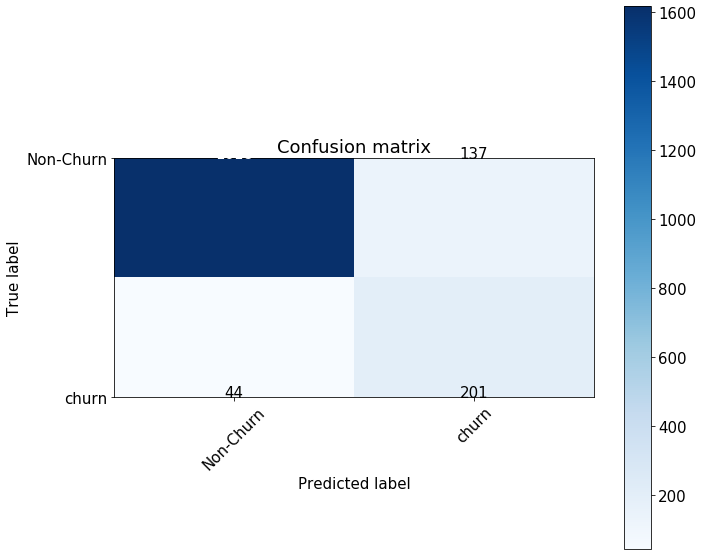

In [55]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [56]:
metrics = (metrics_basic, metrics_mod_median, metrics_mod_max)

table = pd.DataFrame(list(metrics), columns=['f-score', 'precision', 'recall', 'roc-auc'], index=['mean', 'median', 'max'])

In [57]:
table

,f-score,precision,recall,roc-auc
mean,0.623563,0.538462,0.740614,0.927746
median,0.691781,0.595870,0.824490,0.951483
max,0.691781,0.595870,0.824490,0.951483


Возможно при использовании медианы показатели выше чем при использовании среднего, потому что она эффективнее работает с выбросами.

Не могу понять почему, но переодически при запуске модели метрики precision	и recall равны 0, а f-score = Nan.
Буду признательна, если объясните, почему такое происходит